# A comparison of 10K cohort thrombolysis rates across hospitals - adjusting learning rates

## Aims:

* Train XGBoost model on all data except for a 10K set of patients
* Predict use of thrombolysis in 10K cohort at each of 132 hospitals (by changing hospital one-hot coding).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

In [3]:
data_loc = './data/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

## Combined XGBoost Model

### Train model

In [4]:
models = []
accuracies = []

# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

learning_rates = [0.01, 0.1, 0.3, 0.5, 0.70, 1]

for lr in learning_rates:

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=lr)

    # Fit model
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)
    print (f'LR: {lr}, Accuracy: {accuracy:0.3f}')

LR: 0.01, Accuracy: 0.8324
LR: 0.1, Accuracy: 0.8499
LR: 0.3, Accuracy: 0.852
LR: 0.5, Accuracy: 0.8497
LR: 0.7, Accuracy: 0.8455
LR: 1, Accuracy: 0.8341


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [5]:
hospitals = list(set(train['StrokeTeam']))
hospitals.sort()

thrombolysis_rates_by_lr = []

for i in range(len(learning_rates)):
    
    model = models[i]
    thrombolysis_rate = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)

        # Get predicted probabilities and class
        y_probs = model.predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    thrombolysis_rates_by_lr.append(thrombolysis_by_hosp)      


### Plot thrombolysis rate of 10K cohort at each hospital

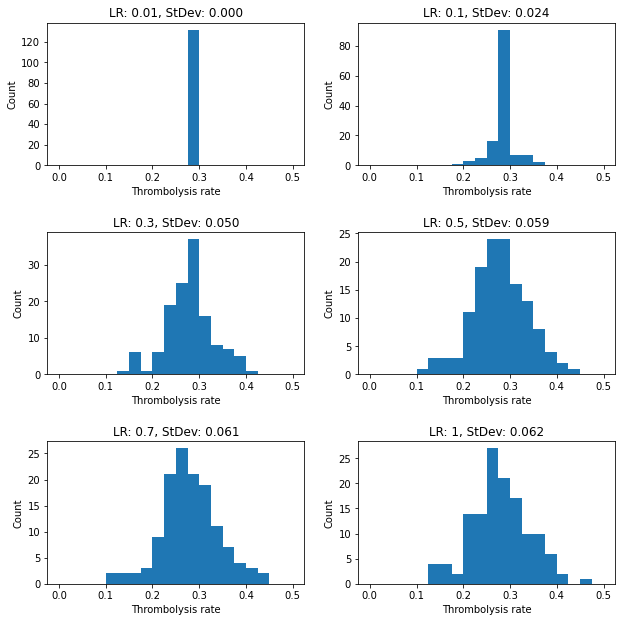

In [6]:
fig = plt.figure(figsize=(9, 9))

for i, thrombolysis_rate in enumerate(thrombolysis_rates_by_lr):

    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(thrombolysis_rate,
            bins=np.arange(0.0, 0.51, 0.025),
            histtype='bar',
            label = learning_rates[i])
    ax.set_xlabel('Thrombolysis rate')
    ax.set_ylabel('Count')
    
    stdev = np.std(thrombolysis_rate['Thrombolysis rate'])
    ax.set_title(f'LR: {learning_rates[i]}, StDev: {stdev:0.3f}')

plt.tight_layout(pad=2)
plt.show()

### Show stats

In [7]:
for i, thrombolysis_rate in enumerate(thrombolysis_rates_by_lr):
    mean = np.mean(thrombolysis_rate['Thrombolysis rate'])
    stdev = np.std(thrombolysis_rate['Thrombolysis rate'])
    minimum = np.min(thrombolysis_rate['Thrombolysis rate'])
    maximum = np.max(thrombolysis_rate['Thrombolysis rate'])

    print (f'Learning rate: {learning_rates[i]}')
    print (f'Mean: {mean:0.3f}')
    print (f'StDev: {stdev:0.3f}')
    print (f'Min: {minimum:0.3f}')
    print (f'Max: {maximum:0.3f}')
    print ()

Learning rate: 0.01
Mean: 0.280
StDev: 0.000
Min: 0.280
Max: 0.280

Learning rate: 0.1
Mean: 0.280
StDev: 0.024
Min: 0.199
Max: 0.361

Learning rate: 0.3
Mean: 0.278
StDev: 0.050
Min: 0.136
Max: 0.407

Learning rate: 0.5
Mean: 0.278
StDev: 0.059
Min: 0.105
Max: 0.427

Learning rate: 0.7
Mean: 0.280
StDev: 0.061
Min: 0.115
Max: 0.433

Learning rate: 1
Mean: 0.279
StDev: 0.062
Min: 0.128
Max: 0.470

